In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

In [2]:
data_import = pd.read_csv('../Data/LT_DU_data_for_ML_All_variations.csv') # All variations of categorical and numeric transformations
data_import.columns

Index(['lpk', 'hourly_rate', 'experience', 'weeks', 'vacation',
       'esize_class_ord', 'esize_class_orig', 'esize_class_oh_1_49',
       'esize_class_oh_50_249', 'esize_class_oh_GT_250', 'gender_orig',
       'gender_M', 'age_class_ord', 'age_class_orig', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+', 'education_ord', 'education_orig',
       'education_oh_G1', 'education_oh_G2', 'education_oh_G3',
       'education_oh_G4', 'outlier', 'nace_orig', 'nace_B', 'nace_C', 'nace_D',
       'nace_E', 'nace_F', 'nace_G', 'nace_H', 'nace_I', 'nace_J', 'nace_K',
       'nace_L', 'nace_M', 'nace_N', 'nace_O', 'nace_P', 'nace_Q', 'nace_R',
       'nace_S', 'hourly_rate_norm', 'experience_sc', 'weeks_sc',
       'vacation_sc'],
      dtype='object')

# Data selection and filtering

## Parameters

In [3]:
#Normalize 'hourly_rate' ('no'/'yes')?
normalize = 'no'
#Select lpk level. Valid options: '1' (0), '2' (00), '3' (000).
lpk_level = 3
#Remove outliers ('no'/'yes')?
remove_outliers = 'yes'
#Remove upper boundary ('no'/'yes')?
upper_boundary = 15
remove_above_boundary = 'no'
#Remove below minimal wage ('no'/'yes')?
lower_boundary = 2.45
remove_below_boundary = 'no'
#Use scaled numeric features ('no'/'yes')?
use_numeric = 'no'
#Use ordinary or one hot encoding for 'esize_class_ord', 'age_class_ord', 'education_ord'?
#'no' use One Hot, 'yes' use ordinary
use_ordinary = 'no'
#Use nace One Hot ('no'/'yes')?
nace_one_hot = 'yes'


## Selection and filtering

In [4]:
data=data_import.copy()

#Normalize 'hourly_rate' ('no'/'yes')?
if normalize == 'no':
    data.drop(columns=['hourly_rate_norm'], inplace=True)
    target='hourly_rate'
else:
    data.drop(columns=['hourly_rate'], inplace=True)
    target='hourly_rate_norm'

print(f'Target label is "{target}"')

#One Hot encoding for selected lpk level
lpk_level_label = 'lpk_'+str(lpk_level)
data[lpk_level_label] = data['lpk'] // (10**(3-lpk_level))
data = pd.get_dummies(data, prefix='lpk' ,columns=[lpk_level_label])
print(f'LPK encoded using {lpk_level_label}')

#Outliers
if remove_outliers == 'yes':
    data=data.query('outlier==False')
    print('Outliers removed')
else:
    print('Outliers retained')

# Include upper boundary?
if remove_above_boundary == 'yes':
    data=data.query('hourly_rate <= @upper_boundary')
    print('Target values above boundary are removed')
else:
    print('All records above boundary retained')

#Remove below minimal wage?
if remove_below_boundary == 'yes':
    data=data.query('hourly_rate >= @lower_boundary')
    print('All records below minimal wage are removed')
else:
    print('All records below minimal wage retained')

#Use scaled numeric features?
if use_numeric == 'no':
    data.drop(columns=['experience_sc', 'weeks_sc', 'vacation_sc'], inplace=True)
    print('Scaled numeric features are removed')
else:
    print('Scaled numeric features are used')

#Use ordinary or one hot encoding for 'esize_class', 'age_class', 'education'?
if use_ordinary == 'yes':
    data.drop(columns=data.columns[data.columns.str.contains('_oh_')], inplace= True)
    print('Ordinari encoding for esize_class, age_class, education used')
else:
    data.drop(columns=data.columns[data.columns.str.contains('_ord')], inplace= True)
    print('One hot encoding for esize_class, age_class, education used')

 #Use nace One Hot ('no'/'yes')?
if nace_one_hot == 'no':
    data.drop(columns=data.columns[data.columns.str.contains('nace_')], inplace= True)
    print('Original nace values')
else:
    data.drop(columns='nace_orig', inplace= True)
    print('One hot encoding used for nace ')   

#Remove meta columns (not used in ML development)
remove_col = ['lpk', 'outlier',
             'esize_class_orig','gender_orig','age_class_orig','education_orig',
             'experience', 'weeks', 'vacation']
data.drop(columns=remove_col, inplace=True )

Target label is "hourly_rate"
LPK encoded using lpk_3
Outliers removed
All records above boundary retained
All records below minimal wage retained
Scaled numeric features are removed
One hot encoding for esize_class, age_class, education used
One hot encoding used for nace 


In [5]:
data.columns

Index(['hourly_rate', 'esize_class_oh_1_49', 'esize_class_oh_50_249',
       'esize_class_oh_GT_250', 'gender_M', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+',
       ...
       'lpk_835', 'lpk_911', 'lpk_912', 'lpk_921', 'lpk_931', 'lpk_932',
       'lpk_933', 'lpk_941', 'lpk_961', 'lpk_962'],
      dtype='object', length=145)

# Prepare X and y

In [6]:
y = data[target]
X = data.drop(columns=target)
y.shape , X.shape

((35170,), (35170, 144))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((28136,), (7034,))

In [8]:
y_train_mean = np.mean(y_train)
y_train_mean.round(2)

5.17

# Model and predictions

## Initial model

In [28]:
from sklearn.svm import NuSVR
model = NuSVR(cache_size=1000)
model.fit(X=X_train,y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

In [29]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.845  R2= 0.563
Test: RMSE= 1.904  R2= 0.519


## Grid search CV (Very slow)

In [17]:
""" from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
model = NuSVR(cache_size=5000)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = {
       "nu": np.linspace(0.1, 0.9, 5),
       "gamma": np.logspace(-2, 1, 4)
       }
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)
results.best_params_ """

{'gamma': 0.1, 'nu': 0.5}

best for RMSE {'gamma': 0.1, 'nu': 0.5} 342 min

In [24]:
""" from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
model = NuSVR(cache_size=5000)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = {
       "nu": np.linspace(0.1, 0.9, 5),
       "gamma": np.logspace(-2, 1, 4)
       }
search = GridSearchCV(model, grid, scoring='r2', cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)
results.best_params_ """

{'gamma': 0.1, 'nu': 0.5}

best for R2 {'gamma': 0.1, 'nu': 0.5}

In [25]:
""" best_model=results.best_estimator_
best_model """

NuSVR(cache_size=5000, gamma=0.1)

In [26]:
""" y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100 """

In [27]:
""" print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3)) """

Train: RMSE= 1.905  R2= 0.534
Test: RMSE= 1.922  R2= 0.509


Train: RMSE= 1.905  R2= 0.534
Test: RMSE= 1.922  R2= 0.509

## Model with best hyperparameters

In [30]:
from sklearn.svm import NuSVR
model = NuSVR(cache_size=1000, gamma=0.1, nu=0.5)
model.fit(X=X_train,y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

In [31]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.905  R2= 0.534
Test: RMSE= 1.922  R2= 0.509


Results are worse, but parameters optimised using cross validation

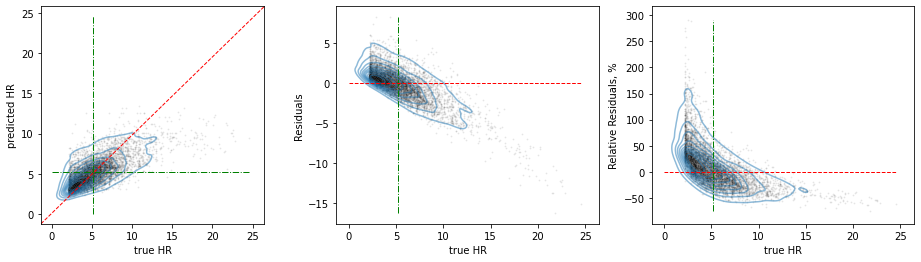

In [32]:

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.scatterplot(ax=ax[0], x=y_test, y=y_test_pred,  s=3, color='black', alpha=0.1)
sns.kdeplot(ax=ax[0],  x=y_test, y=y_test_pred, alpha=0.5 )
ax[0].set_xlabel('true HR')
ax[0].set_ylabel('predicted HR')
ax[0].set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax[0].plot((0,1), (0, 1), transform=ax[0].transAxes, linestyle='--', color='r', lw=1)
ax[0].vlines(ymin=0, ymax=max(y_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[0].hlines(xmin=0, xmax=max(y_test) , y=y_train_mean, linestyle='-.', color='g', lw=1)

sns.scatterplot(ax=ax[1],  x=y_test, y=residuals_test,  s=3, color='black', alpha=0.1)
sns.kdeplot(ax=ax[1], x=y_test, y=residuals_test, alpha=0.5 )
ax[1].set_xlabel('true HR')
ax[1].set_ylabel('Residuals')
ax[1].vlines(ymin=min(residuals_test), ymax=max(residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[1].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1)

sns.scatterplot(ax=ax[2],  x=y_test, y=r_residuals_test,  s=3, color='black', alpha=0.1)
sns.kdeplot(ax=ax[2],  x=y_test, y=r_residuals_test, alpha=0.5 )
ax[2].set_xlabel('true HR')
ax[2].set_ylabel('Relative Residuals, %')
ax[2].vlines(ymin=min(r_residuals_test), ymax=max(r_residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[2].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1);

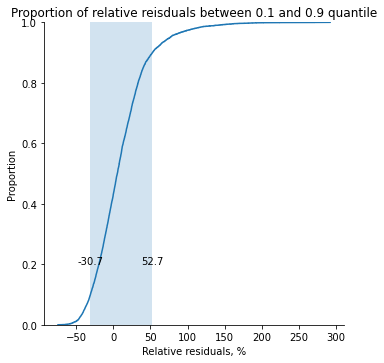

In [33]:
x1=np.quantile(r_residuals_test, 0.10)
x2=np.quantile(r_residuals_test, 0.90)
sns.displot(r_residuals_test, kind='ecdf',)
plt.xlabel('Relative residuals, %')
plt.fill_betweenx(y=[0,1], x1=x1, x2=x2, alpha=0.2)
plt.text(x=x1, y=0.2, s=x1.round(1), ha='center')
plt.text(x=x2, y=0.2, s=x2.round(1), ha='center')
plt.title('Proportion of relative reisduals between 0.1 and 0.9 quantile');